In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Loading and exploring the data

In [2]:
p= "reddit_annoted.csv"
df = pd.read_csv(p)
df.head()

,text,subreddit,bucket,annotator,annotation,confidence
0,MLP doesn't need to wait for a referendum to b...,europe,French politics,annotator00,Authority,Not Confident
1,Or - or - assclowns like Le Pen and Farage cou...,worldnews,French politics,annotator02,Equality,Confident
2,Congratulations on your victory Macron voters....,worldnews,French politics,annotator00,Care,Not Confident
3,The German Constitution did not let Hitler bec...,neoliberal,French politics,annotator02,Equality,Somewhat Confident
4,So Republicans really are for liberal policies...,politics,US Politics,annotator03,Equality,Confident


<AxesSubplot:ylabel='subreddit'>

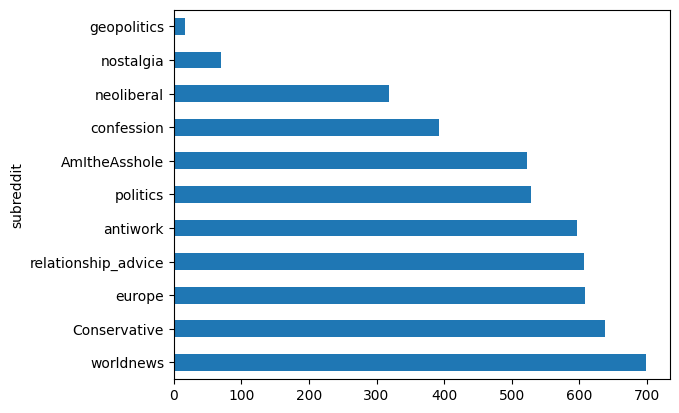

In [3]:
df.subreddit.value_counts().plot(kind = 'barh')

In [4]:
#before starting to do any analysis we will only take the annotations where annotators wwere confident
df.drop(np.where(df.confidence != 'Confident')[0], inplace = True)
df.head()

,text,subreddit,bucket,annotator,annotation,confidence
1,Or - or - assclowns like Le Pen and Farage cou...,worldnews,French politics,annotator02,Equality,Confident
4,So Republicans really are for liberal policies...,politics,US Politics,annotator03,Equality,Confident
6,&gt; How about the fact that the majority of M...,europe,French politics,annotator01,"Authority,Proportionality",Confident
7,What proportion of tipped workers don't want i...,antiwork,US Politics,annotator04,Proportionality,Confident
8,'I think capitalists are loathsome parasites t...,antiwork,US Politics,annotator02,Equality,Confident


## Next i only one one label per anotation.

In [5]:
labels = ["Care", "Authority", "Equality", "Proportionality", "Loyalty", "Purity"]
unwanted = [label for label in df.annotation if label not in labels]
unwanted_ = np.unique(unwanted)


In [6]:
#choosing only one of the labels for each annotation containing more than one label
for anno in unwanted_:
    ann = anno.split(sep = ',')
    #randomly selecting a label since all the annotators are confident in all the labels
    val = np.random.randint(len(ann), size=1)
    df.loc[df['annotation'] == anno, 'annotation'] = ann[val[0]]
   

In [7]:
df.iloc[np.where(df.annotation == "Non-Moral")[0]]

,text,subreddit,bucket,annotator,annotation,confidence
4074,McConnell is always uncertain about things tha...,politics,US Politics,annotator02,Non-Moral,Confident


In [8]:
df.drop(np.where(df.annotation == "Care,Thin")[0], inplace = True)
df.drop(4074, inplace = True)
df.annotation.value_counts()

annotation
Care               896
Equality           836
Authority          631
Proportionality    590
Purity             253
Loyalty            251
Name: count, dtype: int64

<AxesSubplot:ylabel='annotation'>

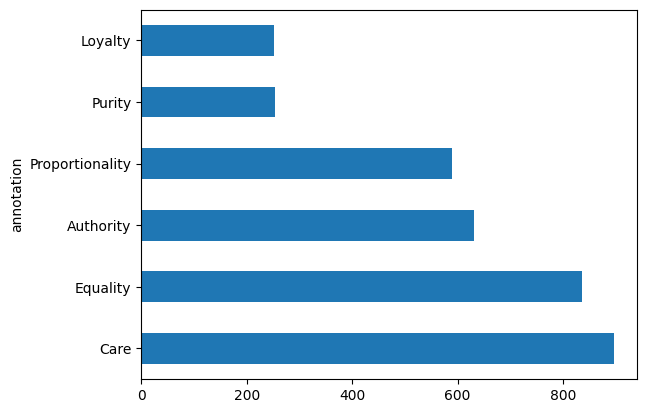

In [9]:
df.annotation.value_counts().plot(kind = 'barh')

### Because the data is highly imbalance a resampling technique will be use so that the model can accurately predict the sentiment in the text.

# CLEANING TEXT DATA


Text data from social platforms is one of the most challenging data types there is. This is because the data needs to go throught many steps before is use. The comments in the platforms have many misspellings, odd abreviations, emojis and names of people commenters are often responding to in the comments. This ie beyong the standard HTML characters found n text gather from the web.

In [10]:
from cleantext import clean

In [11]:
df.text.values

array(["Or - or - assclowns like Le Pen and Farage could have demonstrated that they have ethics and morals by refuse to use money they've received *from the very institution they're trying to destroy*.  \n\nThat they did not shows exactly what sort of power-hungry hypocrites they are.",
       'So Republicans really are for liberal policies just also with a lot of racism.',
       "&gt; How about the fact that the majority of Melenchon voters went for Macron\n\n[It was more around 50/50](https://www.ft.com/__origami/service/image/v2/images/raw/http%3A%2F%2Fcom.ft.imagepublish.prod.s3.amazonaws.com%2F6c47766a-3377-11e7-bce4-9023f8c0fd2e?source=next&amp;fit=scale-down&amp;width=700)\n\nWith the other 50% either abstaining (majority) and a smaller voting for Le Pen.\n\n&gt; Please explain how this helped Le Pen: 'Factually a lift gotten from'\n\nEvery non-vote doesn't count, increasing the representative percentage of every candidate ergo Le Pen got bigger numbers than she really represe

At first loook the data contains a lot of the following characters: \n\n, *, REEEE, \,  Oooof, &, url, -, links, etc

In [63]:
!pip install emoji

In [72]:
!pip install emot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 461.4 kB/s eta 0:00:00a 0:00:01


## Creating function to convert emojis to text

In [133]:
import emoji

text = 'I love Python ❤️, it is brilliant 👍'
emoji.demojize(text )

'I love Python :red_heart:, it is brilliant :thumbs_up:'

In [134]:
def emoji_to_text(text):
    return emoji.demojize(text)

In [135]:
import re
from cleantext.sklearn import CleanTransformer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jenifervivar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [136]:
porter = PorterStemmer()
stop = stopwords.words('english')
def tokenizer_porter(text):
    return np.array([porter.stem(w) for w in text.split() if w not in stop])

In [137]:
def stopWordsRemoval(text):
    text = text.lower()
    comm_split = text.split()
    t = ''
    i = 0
    for w in comm_split:
        if w not in stop: 
            if i <len(comm_split)-1:
                t = t + w + " "
                i+=1
            if i>= len(comm_split)-1:
                t = t + w
        else:
            i+=1
            
    return t

In [129]:
cleaner = CleanTransformer(
    fix_unicode=False,
    to_ascii=False,
    lower=True,
    normalize_whitespace=True,
    no_line_breaks=False,
    strip_lines=False,
    keep_two_line_breaks=False,
    no_urls=True,
    no_emails=True,
    no_phone_numbers=False,
    no_numbers=True,
    no_digits=True,
    no_currency_symbols=True,
    no_punct=True,
    no_emoji=False,
    replace_with_url='',
    replace_with_email='',
    replace_with_phone_number='',
    replace_with_number='',
    replace_with_digit='',
    replace_with_currency_symbol='',
    replace_with_punct='',
    lang='en',
)

In [130]:
df['text_clean'] =  cleaner.transform(df.text)
df['text_clean'] = np.array([emoji_to_text(t) for t in df.text_clean])
#df['text_clean'] = np.array([re.sub('-', " ", t) for t in df.text_clean])
df['text_clean'] = np.array([re.sub('[>*^~]', "", t) for t in df.text_clean])
df['text_clean'] = np.array([stopWordsRemoval(t) for t in df.text_clean])

df["tokenized_text"] = [tokenizer_porter(comment) for comment in df.text_clean]

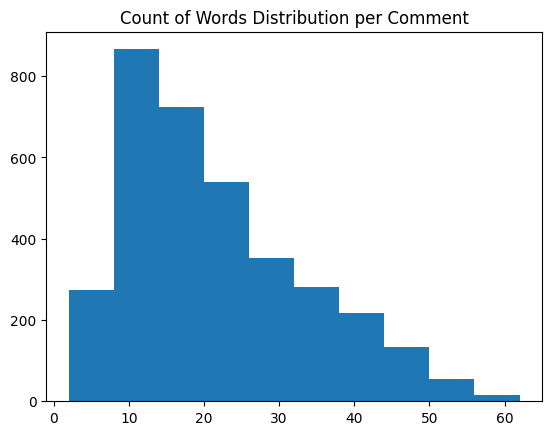

In [125]:
word_size = [len(arr) for arr in df.tokenized_text]
plt.hist(word_size)
plt.title("Count of Words Distribution per Comment")
plt.show()

## The data is now cleaned and ready to be process with machine learning techniques

# Machile learning data pre-processing
The data contains text data that needs to be converted to numerical data for the models to evealuated better.
In this example we will use a bag of words model to get the word frecuency.


In [77]:
X = df.text_clean
y = df.annotation

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import HashingVectorize
from imblearn.over_sampling import SMOTENC

In [193]:
from imblearn.over_sampling import SMOTEN
sampler = SMOTEN(random_state=0)
X_res, y_res = sampler.fit_resample(X.to_numpy().reshape(-1, 1), y)

/Users/jenifervivar/opt/anaconda3/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:731: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  stats.mode(X_class[nn_indices[samples_indices]], axis=1).mode, axis=1
/Users/jenifervivar/opt/anaconda3/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:731: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminat

In [195]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
sampler = SMOTEN(random_state=0)
X_train_bal, y_train_bal = sampler.fit_resample(X_train.to_numpy().reshape(-1, 1), y_train)

/Users/jenifervivar/opt/anaconda3/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:731: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  stats.mode(X_class[nn_indices[samples_indices]], axis=1).mode, axis=1
/Users/jenifervivar/opt/anaconda3/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:731: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminat

In [196]:
pipe= Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('svc', SVC(C=500, random_state=42)),
              ])


In [197]:
pipe.fit(X_train, y_train)
y_hat = pipe.predict(X_test)
accuracy_score(y_test, y_hat)

0.43352601156069365

In [198]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_hat,target_names=df.annotation.value_counts().index.values))

                 precision    recall  f1-score   support

           Care       0.37      0.45      0.41       153
       Equality       0.42      0.68      0.52       216
      Authority       0.52      0.58      0.55       214
Proportionality       0.60      0.09      0.15        68
         Purity       0.37      0.18      0.24       151
        Loyalty       0.33      0.05      0.08        63

       accuracy                           0.43       865
      macro avg       0.44      0.34      0.33       865
   weighted avg       0.43      0.43      0.40       865



In [206]:
pipe= Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('svc', SVC(class_weight = 'balanced', random_state=42)),
              ])

c_vals = [1.0, 10.0, 100.0, 120.0, 150.0, 1000.0]

params_grid = [{"svc__C": c_vals,
                'svc__kernel': ['linear']
                },
                {"svc__C": c_vals,
                'svc__kernel': ["poly"],
                'svc__gamma': c_vals
                },
               
                {"svc__C": c_vals,
                'svc__kernel': ['rbf'],
                'svc__gamma': c_vals
                }
                ] 


In [207]:
from sklearn.model_selection import RandomizedSearchCV

grid_search = RandomizedSearchCV(estimator = pipe,\
                                 param_distributions = params_grid,\
                                 scoring = 'accuracy',\
                                 refit = True,
                                 random_state= 42
                                )

gs_result = grid_search.fit(X_train, y_train)
print(gs_result.best_params_)

{'svc__kernel': 'rbf', 'svc__gamma': 1.0, 'svc__C': 150.0}


In [208]:
pipe= Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('svc', SVC(C=150, random_state=42, gamma= 1, class_weight= 'balanced')),
              ])
pipe.fit(X_train, y_train)
y_hat = pipe.predict(X_test)
accuracy_score(y_test, y_hat)

0.42427745664739885

In [209]:
print(classification_report(y_test, y_hat,target_names=df.annotation.value_counts().index.values))

                 precision    recall  f1-score   support

           Care       0.37      0.46      0.41       153
       Equality       0.43      0.64      0.51       216
      Authority       0.50      0.57      0.53       214
Proportionality       0.64      0.10      0.18        68
         Purity       0.31      0.18      0.23       151
        Loyalty       0.27      0.05      0.08        63

       accuracy                           0.42       865
      macro avg       0.42      0.33      0.32       865
   weighted avg       0.42      0.42      0.39       865



# SVM RBF Results
The results for the classifiers were not that bad. The classifier predicted the sentiments with a 42% accuracy. This was an increase on the performance before the class weight was set to balanced and before the data was cleaned throughly.


# Random Forest Algorithm

In [210]:
from sklearn.ensemble import RandomForestClassifier

In [215]:
rf = RandomForestClassifier(random_state=42, class_weight = 'balanced')
criteria = ["gini", "entropy", "log_loss"]
stimators = np.arange(100, 1000, 100)

params_grid_rf = [{"rf__criterion": criteria,
                'rf__n_estimators': stimators
                }] 

pipe= Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('rf', RandomForestClassifier(random_state=42, class_weight = 'balanced')),
              ])

grid_search = RandomizedSearchCV(estimator = pipe,\
                                 param_distributions = params_grid_rf,\
                                 scoring = 'accuracy',\
                                 refit = False,
                                 random_state= 42
                                )

gs_result = grid_search.fit(X_train, y_train)
print(gs_result.best_params_)

{'rf__n_estimators': 900, 'rf__criterion': 'gini'}


In [218]:
pipe= Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('rf', RandomForestClassifier(n_estimators = 900,random_state=42, class_weight = 'balanced')),
              ])

pipe.fit(X_train, y_train)
y_hat = pipe.predict(X_test)
accuracy_score(y_test, y_hat)

0.41040462427745666

In [219]:
print(classification_report(y_test, y_hat,target_names=df.annotation.value_counts().index.values))

                 precision    recall  f1-score   support

           Care       0.35      0.52      0.42       153
       Equality       0.38      0.70      0.49       216
      Authority       0.59      0.46      0.52       214
Proportionality       0.47      0.12      0.19        68
         Purity       0.34      0.08      0.13       151
        Loyalty       0.31      0.06      0.11        63

       accuracy                           0.41       865
      macro avg       0.41      0.32      0.31       865
   weighted avg       0.42      0.41      0.37       865



# Lazy Algorithm

In [220]:
from sklearn.neighbors import KNeighborsClassifier

In [221]:
n_neighbors = np.arange(5, 100, 5)
params_grid_rf = [{"KN__n_neighbors":n_neighbors,
                }] 

pipe= Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('KN', KNeighborsClassifier()),
              ])

grid_search = RandomizedSearchCV(estimator = pipe,\
                                 param_distributions = params_grid_rf,\
                                 scoring = 'accuracy',\
                                 refit = False,
                                 random_state= 42
                                )

gs_result = grid_search.fit(X_train, y_train)
print(gs_result.best_params_)

{'KN__n_neighbors': 70}


In [222]:
pipe= Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('KN', KNeighborsClassifier(n_neighbors = 70)),
              ])

pipe.fit(X_train, y_train)
y_hat = pipe.predict(X_test)
accuracy_score(y_test, y_hat)

0.4

In [223]:
print(classification_report(y_test, y_hat,target_names=df.annotation.value_counts().index.values))

                 precision    recall  f1-score   support

           Care       0.34      0.39      0.36       153
       Equality       0.37      0.69      0.48       216
      Authority       0.49      0.56      0.52       214
Proportionality       1.00      0.01      0.03        68
         Purity       0.39      0.11      0.17       151
        Loyalty       0.00      0.00      0.00        63

       accuracy                           0.40       865
      macro avg       0.43      0.29      0.26       865
   weighted avg       0.42      0.40      0.35       865



/Users/jenifervivar/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jenifervivar/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jenifervivar/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

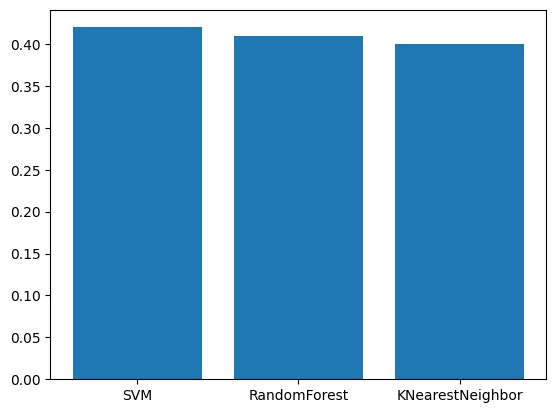

In [226]:
results = [0.42, 0.41, 0.40]
algorithms = ["SVM", "RandomForest", "KNearestNeighbor"]

plt.bar(algorithms, results)
plt.show()

In [227]:
df.to_csv("redditCleanedTokenized.csv",index = False)